# 1. Rectification

The template below first asks the user to upload three files: an image (`IMAGE`) and two point files (`SOURCE_POINTS_FILE` and `TARGET_POINTS_FILE`).
The point files must be in the form
```
    X1 Y1
    X2 Y2
    X3 Y3
    X4 Y4
```
to define four 2D points.

The `rectify()` below maps the image region defined by the four corners from `SOURCE_POINTS_FILE` to the new region defined by `TARGET_POINTS_FILE`, using the functions
* `build_A()`,
* `compute_H()`,
* `bilinear_interp()`, and
* `warp_homography()`.

Complete these functions in the code cells below, and run Step1-1 to Step1-4. These steps simply do
1. Upload an image file as `IMAGE`, (use "laptop.jpg" for testing)
2. Upload an text file as `SOURCE_POINTS_FILE`, (use "laptop_screen.txt" for testing)
3. Upload an text file as `TARGET_POINTS_FILE`, and (use "laptop_rect.txt" for testing)
4. Run `rectify()` and show the output image.


In [2]:
import numpy as np

def build_A(targets,origin):
    """
    Constructs the intermediate matrix A used in the computation of anhomography mapping points_original to points_target.
    targets: N target points in(w,h) format
    origin: N origin points in (w,h) format
    return D:(2*N,9)
    """
    A = np.zeros((2*len(targets),9),dtype=np.float64)
    index= 0
    for (point_target,point_origin) in zip(targets,origin):
        A[index,:]=[point_origin[0],point_origin[1],1,0,0,0,-1*point_origin[0]*point_target[0],-1*point_target[0]*point_origin[1],-1*point_target[0]]
        index+=1
        A[index,:]=[0,0,0,point_origin[0],point_origin[1],1,-1*point_origin[0]*point_target[1],-1*point_origin[1]*point_target[1],-1*point_target[1]]
        index+=1
    return A

In [3]:
def compute_H(points_target, points_origin):
    """Computes an homography mapping one set of co-planar points (pts1) to another (pts2)."""

    # Construct the intermediate A matrix.
    A=build_A(points_target,points_origin)
    # Compute the symmetric matrix AtA.
    A=A.T.dot(A)
    # Compute the eigenvalues and eigenvectors of AtA.
    egvalues,egvectors=np.linalg.eig(A)
    H=egvectors[:,np.argmin(egvalues)]
    # Return the eigenvector corresponding to the smallest eigenvalue, reshaped
    # as a 3x3 matrix.
    return H.reshape((3,3))


In [4]:
def bilinear_interp(image, points):
    """Looks up the pixel values in an image at a given point using bilinear
    interpolation.
    image h,w,C
    points h',w',2
    return h',w',c
    """
    image_new=np.zeros((points.shape[0],points.shape[1],image.shape[2]),dtype=np.float64)
    # Compute the four integer corner coordinates (top-left/right,
    # bottom-left/right) for interpolation, as well as the fractional part of
    # the coordinates.
    
    image=image.astype(np.float64)
    for y in range(points.shape[0]):
         for x in range(points.shape[1]):
                point=points[y,x]
                x_1=np.floor(point[0]).astype(np.int32)
                x_2=(np.floor(point[0])+1).astype(np.int32)
                y_1=(np.floor(point[1])).astype(np.int32)
                y_2=(np.floor(point[1])+1).astype(np.int32)

                if (x_1<0 or x_2>(image.shape[1]-1) or y_1<0 or y_2>(image.shape[0]-1)):
                    image_new[y,x]=0
                else:
                    m=image[y_1,x_1]+(point[0]-x_1)*(image[y_1,x_2]-image[y_1,x_1])
                    # Interpolate between the bottom two pixels.
                    n=image[y_2,x_1]+(point[0]-x_1)*(image[y_2,x_2]-image[y_2,x_1])
                    # Interpolate between the top two pixels.
                    image_new[y,x]=m+(point[1]-y_1)*(n-m)

    # Return the result of the final interpolation between top and bottom.
    #print(f"{image_new.shape}")
    return image_new.astype(np.uint8)


In [5]:
def warp_homography(source, target_shape, Hinv):
    """Warp the source image into the target coordinate frame using a provided
    inverse homography transformation.
    source(H,W,C)
    target_shape=(H',W',C)
    Hinv (3,3)
    return image (H',W',C)
    """
    # NOTE: This can be done much more efficiently (>10x faster) in Python
    # using a series of numpy array operations as opposed to a for loop.
    
    x,y=np.meshgrid(np.arange(target_shape[1]),np.arange(target_shape[0]))
    x=x.astype(np.float64)
    y=y.astype(np.float64)
    points=np.stack([x,y,np.ones_like(x,dtype=np.float64)],axis=2) # H',W',3  (x,y,1)
    
    points=points.dot(Hinv.T) # H',W',3 (x'*c,y'*c,c)
    
    points=points/points[:,:,2].reshape((points.shape[0],points.shape[1],1))  # H',W',3 (x',y'*,1)
    points=points[:,:,:2] # H',W',2 (x',y')
    
    image=bilinear_interp(source, points)
    
    

    # Hints for fast version:
    # * Read about numpy broadcasting rules and reshaping operations.
    # * Look up numpy.mgrid / meshgrid for tips on how to quickly generate an
    #   array containing coordinates of all of the points in an image.
    # * You can modify your bilinear_interp() function to take an array of
    #   points instead of single points. Express the actions in this function
    #   using the aforementioned array operations.

    # Warp the source image to the corresponding coordinate system in the
    # output image by:
    #     * transforming points in the output image to the source image space (using the homography)
    #     * looking up pixel values in the source image at the transformed points (using bilinear interpolation)

    # Return the output image.
    return image



In [6]:
def rectify(image, planar_points, target_points):
    """
    image:(H,W,C)
    planar_points (N,2) in (x,y) format
    target_points: (N,2) in (x,y) format
    """
    # Compute the rectifying homography that warps the planar points to the
    # target rectangular region.
    H=compute_H(target_points, planar_points)

    # Apply the rectifying homography to the bounding box of the planar image
    # to find its corresponding bounding box in the rectified space.
    
    bounding_box_origin=np.array([[0,0,1],[image.shape[1]-1,0,1],
                                  [image.shape[1]-1,image.shape[0]-1,1],[0,image.shape[0]-1,1]],dtype=np.float64)# 4,3 (x,y,1)
    bounding_box_rectified=bounding_box_origin.dot(H.T) # 4,3 (x'c,y'c,c)
    bounding_box_rectified=bounding_box_rectified/bounding_box_rectified[:,2].reshape((bounding_box_rectified.shape[0],1))
    boudning_box_rectified=bounding_box_rectified[:,:2] # 4,2 (x',y')
    print(f"bounding box rectified:\n{bounding_box_rectified} \n bounding_bx_origin:\n{bounding_box_origin}")
    
    

    

    # Offset the rectified bounding box such that its minimum point (the top
    # left corner) lies at the origin of the rectified space.
    ## To make the four corner points of the rectified image lies at the edge of the image
    offset_x=0-np.min(bounding_box_rectified[:,0])
    offset_y=0-np.min(bounding_box_rectified[:,1])
    ratio_x=(image.shape[1]-1)/(np.max(bounding_box_rectified[:,0])+offset_x)
    ratio_y=(image.shape[0]-1)/(np.max(bounding_box_rectified[:,1])+offset_y)
    print(f"offset_x{offset_x}    offset_y{offset_y}  ratio_x{ratio_x} ratio_y{ratio_y}")
    target_points_rectified=(target_points+[offset_x,offset_y])*[ratio_x,ratio_y]
    print(f"target_points_rectified:\n{target_points_rectified}")
    

    # Compute the inverse homography to warp between the offset, rectified
    # bounding box and the bounding box of the input image.
    H_rectified=compute_H(target_points_rectified,planar_points)
    
    
    #bounding box rectified after offset
    bounding_box_rectified=bounding_box_origin.dot(H_rectified.T) # 4,3 (x'c,y'c,c)
    bounding_box_rectified=bounding_box_rectified/bounding_box_rectified[:,2].reshape((bounding_box_rectified.shape[0],1))
    boudning_box_rectified=bounding_box_rectified[:,:2] # 4,2 (x',y')
    print(f"bounding box rectified after offset:\n{bounding_box_rectified}")
    
    
    
    Hinv=np.linalg.inv(H_rectified)
    #Hinv=np.linalg.inv(H)
    
    

    # Perform inverse warping and return the result.
    return warp_homography(image, image.shape, Hinv)


In [7]:
# colaboratory-specific helper functions

import cv2
import numpy as np
import matplotlib.pyplot as plt
import termios
from google.colab import files

def upload_sub(msg):
    print(msg)
    f = files.upload()
    if bool(f) is False:
        return None
    fname = list(f.keys())[0]
    return fname

def upload(msg):
    f = None
    while f is None:
        f = upload_sub(msg)
    return f


ModuleNotFoundError: No module named 'termios'

## Step 1-1: Upload `IMAGE`

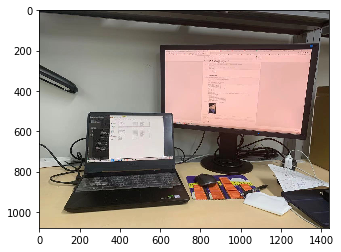

In [8]:
# image = cv2.imread(upload('IMAGE:'), cv2.IMREAD_COLOR) # Use laptop.jpg for testing
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

image =cv2.imread(r"test_data\computer.jpg",cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

## Step 1-2: Upload `SOURCE_POINTS_FILE`

In [9]:
# pts1 = np.loadtxt(upload('SOURCE_POINTS_FILE:')) # Use laptop_screen.txt for testing
# print(pts1)

points_origin=np.loadtxt(r"test_data\computer.txt")
points_origin

array([[ 630.,  200.],
       [1353.,  197.],
       [1301.,  616.],
       [ 626.,  558.]])

## Step 1-3:  TARGET_POINTS_FILE

In [10]:
# pts2 = np.loadtxt(upload('TARGET_POINTS_FILE:')) # Use laptop_rect.txt for testing
# print(pts2)

points_target=np.loadtxt(r"test_data\laptop_rect.txt")
#points_target=np.array([[0,0],[300,0],[300,400],[0,400]],dtype=np.float64)
points_target

array([[  0.,   0.],
       [160.,   0.],
       [160., 120.],
       [  0., 120.]])

## Step 1-4: Rectify

bounding box rectified:
[[-189.46019134  -73.46844315    1.        ]
 [ 171.04819048  -50.44771913    1.        ]
 [ 200.5247982   261.46569743    1.        ]
 [-229.37081253  392.20046113    1.        ]] 
 bounding_bx_origin:
[[0.000e+00 0.000e+00 1.000e+00]
 [1.439e+03 0.000e+00 1.000e+00]
 [1.439e+03 1.079e+03 1.000e+00]
 [0.000e+00 1.079e+03 1.000e+00]]
offset_x229.37081253222777    offset_y73.4684431547391  ratio_x3.347324243566405 ratio_y2.3170969546656353
target_points_rectified:
[[ 767.77848156  170.2335059 ]
 [1303.35036053  170.2335059 ]
 [1303.35036053  448.28514046]
 [ 767.77848156  448.28514046]]
bounding box rectified after offset:
[[1.33593835e+02 2.01103331e-05 1.00000000e+00]
 [1.34033224e+03 5.33412407e+01 1.00000000e+00]
 [1.43900000e+03 7.76074878e+02 1.00000000e+00]
 [1.52055103e-04 1.07899989e+03 1.00000000e+00]]


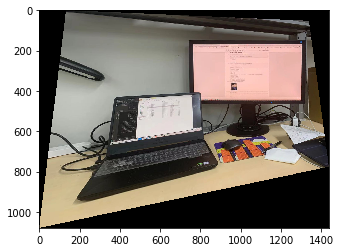

In [11]:
rectified = rectify(image, points_origin, points_target).astype(np.uint8)

plt.imshow(cv2.cvtColor(rectified, cv2.COLOR_BGR2RGB))

# Just in case you want to download the output

# cv2.imwrite("rectified.png", rectified)
# files.download('rectified.png')

# 2. Composition

The function `composite()` below superimposes a region of a `source` image on top of a region of a `target` image. The source and the target regions are specified by corresponding points as done for `rectify()` above.

The function also takes a `mask` image which defines the transparency of `source`. This works as a stencil buffer if `mask` is a binary image, or as an alpha blending mask if grayscale.

In [12]:
def blend_with_mask(source, target, mask):
    """Blends the source image with the target image according to the mask.
    Pixels with value "1" are source pixels, "0" are target pixels, and
    intermediate values are interpolated linearly between the two."""
    mask_source=mask
    mask_target=(mask-1)*(-1)
    image=source*mask_source+target*mask_target
    return image

In [13]:
def composite(source, target, source_pts, target_pts, mask):
    """Composites a masked planar region of the source image onto a
    corresponding planar region of the target image via homography warping.
    source H,W,C
    target H',W',C
    source_pts 4,2
    target_pts 4,2
    mask   H',W'
    
    """

    # Compute the homography to warp points from the target to the source coordinate frame.
    H=compute_H(target_pts, source_pts)
    
    # Warp the images using the homography.
    source_warped=warp_homography(source, target.shape, np.linalg.inv(H))
    mask_warped=warp_homography(mask, target.shape, np.linalg.inv(H))
    mask_warped[mask_warped>0]=1
    

    # Blend the warped images.
    image=blend_with_mask(source_warped, target, mask_warped)
    return image


## Step 2-1: Upload `SOURCE` image

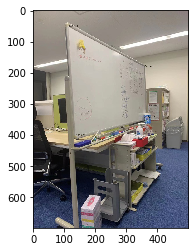

In [14]:
# source = cv2.imread(upload('SOURCE:'), cv2.IMREAD_COLOR) # Use panda.png for testing
# plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))

source = cv2.imread(r"test_data\laboratory.jpg", cv2.IMREAD_COLOR) # Use panda.png for testing
plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))

## Step 2-2: Upload `TARGET` image

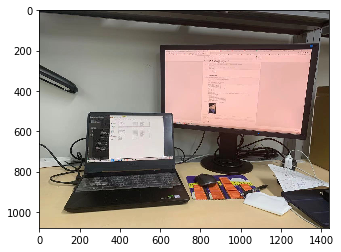

In [15]:
#target = cv2.imread(upload('TARGET:'), cv2.IMREAD_COLOR) # Use laptop.jpg for testing
#plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))

target = cv2.imread(r"test_data\computer.jpg", cv2.IMREAD_COLOR) # Use laptop.jpg for testing
plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))

## Step 2-3: Upload `SOURCE_POINTS` file

In [16]:
source_pts = np.loadtxt(r"test_data\laboratory_boundary_points.txt") # Use panda_point.txt for testing
print(source_pts)

[[  0.   0.]
 [499.   0.]
 [499. 699.]
 [  0. 699.]]


## Step 2-4: Upload `TARGET_POINTS` file

In [17]:
target_pts = np.loadtxt(r"test_data\computer.txt") # Use laptop_screen.txt for testing
print(target_pts)

[[ 630.  200.]
 [1353.  197.]
 [1301.  616.]
 [ 626.  558.]]


## Step 2-5: Upload `MASK` image

(700, 500)
(700, 500, 1)


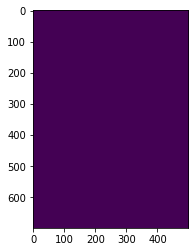

In [18]:
mask = cv2.imread(r"test_data\laboratory_mask.jpg", cv2.IMREAD_GRAYSCALE) # Use panda_mask.png for testing
plt.imshow(mask)
print(mask.shape)

mask = mask[:, :, np.newaxis]
print(mask.shape)

## Step 2-6: Composite

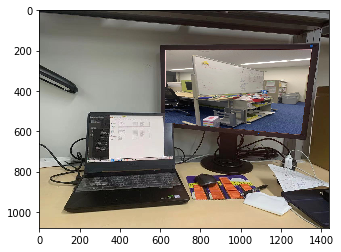

In [19]:
composited = composite(source, target, source_pts, target_pts, mask/255.0).astype(np.uint8)
plt.imshow(cv2.cvtColor(composited, cv2.COLOR_BGR2RGB))